In [1]:
import xgboost as xgb
import optuna
import sklearn.metrics
import numpy as np
import pandas as pd

# Data treatment

In [2]:
train_raw = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')

In [3]:
train_df=train_raw

In [4]:
train_labels = train_raw['Transported']
train_df[['CabinDeck', 'CabinNum', 'CabinSide']] = train_df['Cabin'].str.split('/', n=2, expand=True)
train_df[['GroupId', 'GroupPosition']] = train_df['PassengerId'].str.split('_', n=1, expand=True).astype(int)
train_df = pd.concat([train_df,pd.get_dummies(train_df.Destination)], axis = 1)
train_df.dropna(inplace=True)

df_1 = train_df.groupby(by='GroupId').count().reset_index()[['GroupId','PassengerId']].rename(columns={"GroupId": "GroupId", "PassengerId": "GroupSize"})

train_df['CryoSleep'] = train_df['CryoSleep'].astype(bool)
train_df['TotalSpend'] = train_df['RoomService']+train_df['FoodCourt']+train_df['ShoppingMall']+train_df['Spa']+train_df['VRDeck']
train_df['VIP'] = train_df['VIP'].astype(bool)
train_df['CabinSide'] = train_df['CabinSide'].replace({'S': 0, 'P': 1})
train_df['CabinNum'] = train_df['CabinNum'].astype(int)
train_df['CabinDeck'] = train_df['CabinSide'].replace(
    {'A': 0,
     'B': 1,
     'C': 2,
     'D': 3,
     'E': 4,
     'F': 5,
     'G': 6,
     'T': 7
    })
train_df['HomePlanet'] = train_df['HomePlanet'].replace({'Europa': 0, 'Earth': 1, 'Mars': 2})
train_df = pd.merge(train_df,df_1[['GroupId','GroupSize']],on='GroupId',how='left')
train_df = train_df.drop(['Name','Destination','Cabin','GroupPosition'],axis=1)

/tmp/ipykernel_19/3898334493.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['CabinSide'] = train_df['CabinSide'].replace({'S': 0, 'P': 1})
/tmp/ipykernel_19/3898334493.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['HomePlanet'] = train_df['HomePlanet'].replace({'Europa': 0, 'Earth': 1, 'Mars': 2})


# Dataset Split

In [5]:
def split_dataset(dataset, test_ratio=0.25):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

In [6]:
dft, dfv = split_dataset(train_df)
print("{} examples in training, {} examples in testing.".format(
    len(dft), len(dfv)))

5012 examples in training, 1594 examples in testing.


In [7]:
y= dft['Transported']
Y=dfv['Transported']
x = dfv.drop(['Transported','PassengerId'],axis=1)
X=dft.drop(['Transported','PassengerId'],axis=1)

# Optuna HP Tuning

In [8]:
dtrain = xgb.DMatrix(X, label=dft['Transported'])
dvalid = xgb.DMatrix(x, label=dfv['Transported'])

def objective(trial):
    optuna.logging.set_verbosity(optuna.logging.DEBUG)
    param = {
        'objective': 'binary:logistic',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth',1, 100),
        'max_leaves': trial.suggest_int('max_depth',1, 100),
        'n_estimators': trial.suggest_int('n_estimators',1, 100),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True)
    }    
    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(dfv['Transported'], pred_labels)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2024-03-12 01:40:34,847] A new study created in memory with name: no-name-27ebfe83-1ecd-4ff8-ac3a-6ae930322edd
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:40:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "gamma", "grow_policy", "max_depth", "max_leaves", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-03-12 01:40:34,891] Trial 0 finished with value: 0.501254705144291 and parameters: {'booster': 'gblinear', 'gamma': 0.010527002057831168, 'max_depth': 19, 'n_estimators': 77, 'grow_policy': 'depthwise', 'learning_rate': 0.000672389211835864}. Best is trial 0 with value: 0.501254705144291.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:40:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-03-12 01:40:34,924] Trial 1 finished with value: 0.7528230865746549 and parameters: {'booster': 'gbtree', 'gamma': 

# Model

In [9]:
#Trial 358 finished with value: 0.8149405772495756 and parameters: {'booster': 'gbtree', 'gamma': 0.030185106394347308, 'max_depth': 5, 'n_estimators': 93, 'grow_policy': 'lossguide', 'learning_rate': 0.571705231643359}
#Trial 188 finished with value: 0.8184421534936999 and parameters: {'booster': 'dart', 'gamma': 0.0001266588948421105, 'max_depth': 33, 'n_estimators': 30, 'grow_policy': 'depthwise', 'learning_rate': 0.3888437378144605}
#Trial 701 finished with value: 0.8117079058539529 and parameters: {'booster': 'dart', 'gamma': 0.0014231116611017798, 'max_depth': 21, 'n_estimators': 91, 'grow_policy': 'depthwise', 'learning_rate': 0.7076637158656507}.

In [10]:
model = xgb.XGBRFClassifier(
    booster='dart',
    device='cpu',
    eval_metric=sklearn.metrics.mean_absolute_percentage_error,
    grow_policy = 'depthwise',
    gamma = 0.0014231116611017798,
    max_depth= 21,
    n_estimators = 91,
    learning_rate = 0.7076637158656507
)

In [11]:
model.fit(X,y,eval_set=[(X,y),(x,Y)])

[0]	validation_0-logloss:0.35051	validation_0-mean_absolute_percentage_error:637954309488640.00000	validation_1-logloss:0.46204	validation_1-mean_absolute_percentage_error:801236819378176.00000


XGBRFClassifier(base_score=None, booster='dart', callbacks=None,
                colsample_bylevel=None, colsample_bytree=None, device='cpu',
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=<function mean_absolute_percentage_error at 0x7cea89086170>,
                feature_types=None, gamma=0.0014231116611017798,
                grow_policy='depthwise', importance_type=None,
                interaction_constraints=None, learning_rate=0.7076637158656507,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=21, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=91, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic',
                random_state=None, ...)

In [12]:
trueval = dfv['Transported']
predval = model.predict(x)
sklearn.metrics.accuracy_score(trueval, predval)

0.8111668757841907

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

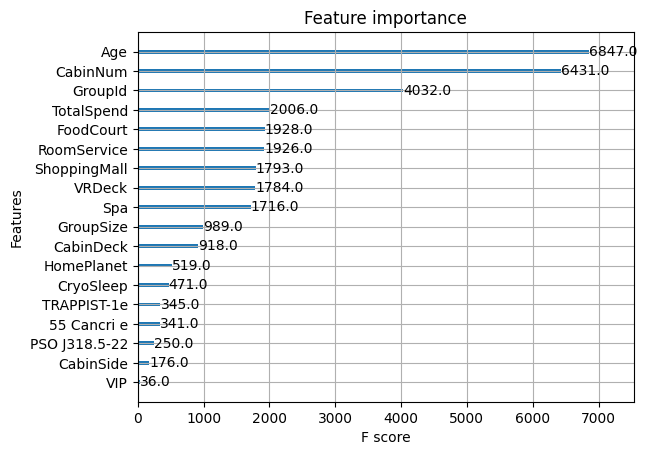

In [13]:
xgb.plot_importance(model)

# Prediction

In [14]:
test_df = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
labels = test_df['PassengerId']

In [15]:
test_df[['CabinDeck', 'CabinNum', 'CabinSide']] = test_df['Cabin'].str.split('/', n=2, expand=True)
test_df[['GroupId', 'GroupPosition']] = test_df['PassengerId'].str.split('_', n=1, expand=True).astype(int)
test_df = pd.concat([test_df,pd.get_dummies(test_df.Destination)], axis = 1)
test_df.fillna(0,inplace=True)

df_2 = test_df.groupby(by='GroupId').count().reset_index()[['GroupId','PassengerId']].rename(columns={"GroupId": "GroupId", "PassengerId": "GroupSize"})


test_df['TotalSpend'] = test_df['RoomService']+test_df['FoodCourt']+test_df['ShoppingMall']+test_df['Spa']+test_df['VRDeck']
test_df['CryoSleep'] = test_df['CryoSleep'].astype(bool)
test_df['VIP'] = test_df['VIP'].astype(bool)
test_df['CabinSide'] = test_df['CabinSide'].replace({'S': 0, 'P': 1})
test_df['CabinNum'] = test_df['CabinNum'].astype(int)
test_df['CabinDeck'] = test_df['CabinSide'].replace(
    {'A': 0,
     'B': 1,
     'C': 2,
     'D': 3,
     'E': 4,
     'F': 5,
     'G': 6,
     'T': 7
    })
test_df['HomePlanet'] = test_df['HomePlanet'].replace({'Europa': 0, 'Earth': 1, 'Mars': 2})
test_df = pd.merge(test_df,df_2[['GroupId','GroupSize']],on='GroupId',how='left')
test_df = test_df.drop(['Name','Destination','Cabin','PassengerId','GroupPosition'],axis=1)

/tmp/ipykernel_19/3307544697.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df['CabinSide'] = test_df['CabinSide'].replace({'S': 0, 'P': 1})
/tmp/ipykernel_19/3307544697.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_df['HomePlanet'] = test_df['HomePlanet'].replace({'Europa': 0, 'Earth': 1, 'Mars': 2})


In [16]:
test_df

,HomePlanet,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,CabinDeck,CabinNum,CabinSide,GroupId,55 Cancri e,PSO J318.5-22,TRAPPIST-1e,TotalSpend,GroupSize
0,1,True,27.0,False,0.0,0.0,0.0,0.0,0.0,0,3,0,13,False,False,True,0.0,1
1,1,False,19.0,False,0.0,9.0,0.0,2823.0,0.0,0,4,0,18,False,False,True,2832.0,1
2,0,True,31.0,False,0.0,0.0,0.0,0.0,0.0,0,0,0,19,True,False,False,0.0,1
3,0,False,38.0,False,0.0,6652.0,0.0,181.0,585.0,0,1,0,21,False,False,True,7418.0,1
4,1,False,20.0,False,10.0,0.0,635.0,0.0,0.0,0,5,0,23,False,False,True,645.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,1,True,34.0,False,0.0,0.0,0.0,0.0,0.0,0,1496,0,9266,False,False,True,0.0,2
4273,1,False,42.0,False,0.0,847.0,17.0,10.0,144.0,0,0,0,9269,False,False,True,1018.0,1
4274,2,True,0.0,False,0.0,0.0,0.0,0.0,0.0,1,296,1,9271,True,False,False,0.0,1
4275,0,False,0.0,False,0.0,2680.0,0.0,0.0,523.0,1,297,1,9273,False,False,False,3203.0,1


In [17]:
test_df['Transported'] = model.predict(test_df)
test_df['PassengerId'] = labels

In [18]:
dfexport = test_df[['PassengerId','Transported']]
dfexport['Transported'] = dfexport['Transported'].replace({0: False, 1: True}).astype(str)

/tmp/ipykernel_19/865874347.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfexport['Transported'] = dfexport['Transported'].replace({0: False, 1: True}).astype(str)
/tmp/ipykernel_19/865874347.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfexport['Transported'] = dfexport['Transported'].replace({0: False, 1: True}).astype(str)


In [19]:
dfexport

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True


In [20]:
dfexport.to_csv('submission.csv')

In [21]:
# The fillna method is trash
